In [1]:
import numpy as np
import pandas as pd
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.externals import joblib
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import math
import json
import pydotplus
from sklearn.externals.six import StringIO
from IPython.display import Image  

## Load the Lending Club Dataset

In [2]:
loans = pd.read_csv('lending-club-data.csv',low_memory=False)

In [3]:
loans.head(2)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,sub_grade_num,delinq_2yrs_zero,pub_rec_zero,collections_12_mths_zero,short_emp,payment_inc_ratio,final_d,last_delinq_none,last_record_none,last_major_derog_none
0,1077501,1296599,5000,5000,4975,36 months,10.65,162.87,B,B2,...,0.4,1.0,1.0,1.0,0,8.1435,20141201T000000,1,1,1
1,1077430,1314167,2500,2500,2500,60 months,15.27,59.83,C,C4,...,0.8,1.0,1.0,1.0,1,2.3932,20161201T000000,1,1,1


In [4]:
loans.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'is_inc_v', 'issue_d',
       'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose', 'title',
       'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'policy_code', 'not_compliant', 'status', 'inactive_loans', 'bad_loans',
       'emp_length_num', 'grade_num', 'sub_gra

## Exploring the target column

In [5]:
loans['safe_loans'] = loans['bad_loans'].apply(lambda x: +1 if x==0 else -1)

In [6]:
loans.drop('bad_loans', axis=1, inplace=True)

In [7]:
loans.safe_loans.value_counts(normalize=True)

 1    0.811185
-1    0.188815
Name: safe_loans, dtype: float64

## Features for the classification algorithm

In [8]:
features = ['grade',                     # grade of the loan
            'sub_grade',                 # sub-grade of the loan
            'short_emp',                 # one year or less of employment
            'emp_length_num',            # number of years of employment
            'home_ownership',            # home_ownership status: own, mortgage or rent
            'dti',                       # debt to income ratio
            'purpose',                   # the purpose of the loan
            'term',                      # the term of the loan
            'last_delinq_none',          # has borrower had a delinquincy
            'last_major_derog_none',     # has borrower had 90 day or worse rating
            'revol_util',                # percent of available credit being used
            'total_rec_late_fee',        # total late fees received to day
           ]

target = 'safe_loans'                    # prediction target (y) (+1 means safe, -1 is risky)

# Extract the feature columns and target column
loans = loans[features + [target]]

## One Hot Encoding & Training and Validation data creation

In [9]:
loans = pd.get_dummies(loans)

In [10]:
loans.columns

Index(['short_emp', 'emp_length_num', 'dti', 'last_delinq_none',
       'last_major_derog_none', 'revol_util', 'total_rec_late_fee',
       'safe_loans', 'grade_A', 'grade_B', 'grade_C', 'grade_D', 'grade_E',
       'grade_F', 'grade_G', 'sub_grade_A1', 'sub_grade_A2', 'sub_grade_A3',
       'sub_grade_A4', 'sub_grade_A5', 'sub_grade_B1', 'sub_grade_B2',
       'sub_grade_B3', 'sub_grade_B4', 'sub_grade_B5', 'sub_grade_C1',
       'sub_grade_C2', 'sub_grade_C3', 'sub_grade_C4', 'sub_grade_C5',
       'sub_grade_D1', 'sub_grade_D2', 'sub_grade_D3', 'sub_grade_D4',
       'sub_grade_D5', 'sub_grade_E1', 'sub_grade_E2', 'sub_grade_E3',
       'sub_grade_E4', 'sub_grade_E5', 'sub_grade_F1', 'sub_grade_F2',
       'sub_grade_F3', 'sub_grade_F4', 'sub_grade_F5', 'sub_grade_G1',
       'sub_grade_G2', 'sub_grade_G3', 'sub_grade_G4', 'sub_grade_G5',
       'home_ownership_MORTGAGE', 'home_ownership_OTHER', 'home_ownership_OWN',
       'home_ownership_RENT', 'purpose_car', 'purpose_credit_card'

In [11]:
loans.head()

,short_emp,emp_length_num,dti,last_delinq_none,last_major_derog_none,revol_util,total_rec_late_fee,safe_loans,grade_A,grade_B,...,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_small_business,purpose_vacation,purpose_wedding,term_ 36 months,term_ 60 months
0,0,11,27.65,1,1,83.7,0.00,1,0,1,...,0,0,0,0,0,0,0,0,1,0
1,1,1,1.00,1,1,9.4,0.00,-1,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,11,8.72,1,1,98.5,0.00,1,0,0,...,0,0,0,0,0,1,0,0,1,0
3,0,11,20.00,0,1,21.0,16.97,1,0,0,...,0,0,0,0,1,0,0,0,1,0
4,0,4,11.20,1,1,28.3,0.00,1,1,0,...,0,0,0,0,0,0,0,1,1,0


In [12]:
train_index = pd.read_json('module-5-assignment-1-train-idx.json')
train_index = list(train_index[0])

In [13]:
val_index = pd.read_json('module-5-assignment-1-validation-idx.json')
val_index = list(val_index[0])

In [14]:
train_data = loans.iloc[train_index]
validation_data = loans.iloc[val_index]

In [15]:
print('Training set   : %d data points' % len(train_data))
print('Validation set : %d data points' % len(validation_data))

Training set   : 37224 data points
Validation set : 9284 data points


In [16]:
train_data.safe_loans.value_counts(normalize=True)

 1    0.503654
-1    0.496346
Name: safe_loans, dtype: float64

In [17]:
validation_data.safe_loans.value_counts(normalize=True)

-1    0.503447
 1    0.496553
Name: safe_loans, dtype: float64

## Build a decision tree classifier  

In [18]:
train_data.safe_loans.value_counts(normalize=True)

 1    0.503654
-1    0.496346
Name: safe_loans, dtype: float64

In [19]:
y = train_data['safe_loans'].as_matrix()

In [20]:
X = train_data.drop('safe_loans',axis=1).as_matrix()

In [46]:
clf = DecisionTreeClassifier(max_depth=6)
decision_tree_model = clf.fit(X,y)

In [32]:
clf2 = DecisionTreeClassifier(max_depth=2)
small_model = clf2.fit(X,y)

## Making predictions

In [23]:
validation_safe_loans = validation_data[validation_data['safe_loans'] == 1]
validation_risky_loans = validation_data[validation_data['safe_loans'] == -1]

sample_validation_data_risky = validation_risky_loans[0:2]
sample_validation_data_safe = validation_safe_loans[0:2]

sample_validation_data = sample_validation_data_safe.append(sample_validation_data_risky)
sample_validation_data

,short_emp,emp_length_num,dti,last_delinq_none,last_major_derog_none,revol_util,total_rec_late_fee,safe_loans,grade_A,grade_B,...,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_small_business,purpose_vacation,purpose_wedding,term_ 36 months,term_ 60 months
19,0,11,11.18,1,1,82.4,0.0,1,0,1,...,0,0,0,0,0,0,0,0,1,0
79,0,10,16.85,1,1,96.4,0.0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
24,0,3,13.97,0,1,59.5,0.0,-1,0,0,...,0,0,0,0,1,0,0,0,0,1
41,0,11,16.33,1,1,62.1,0.0,-1,1,0,...,0,0,0,0,0,0,0,0,1,0


In [24]:
decision_tree_model.predict(sample_validation_data.drop('safe_loans',axis=1).as_matrix())

array([ 1, -1, -1,  1])

In [25]:
sample_validation_data['safe_loans']

19    1
79    1
24   -1
41   -1
Name: safe_loans, dtype: int64

## Explore probability predictions

In [26]:
decision_tree_model.predict_proba(sample_validation_data.drop('safe_loans', axis=1).as_matrix())

array([[ 0.34156543,  0.65843457],
       [ 0.53630646,  0.46369354],
       [ 0.64750958,  0.35249042],
       [ 0.20789474,  0.79210526]])

In [27]:
small_model.predict_proba(sample_validation_data.drop('safe_loans',axis=1).as_matrix())

array([[ 0.41896585,  0.58103415],
       [ 0.59255339,  0.40744661],
       [ 0.59255339,  0.40744661],
       [ 0.23120112,  0.76879888]])

## Visualize the prediction on a tree

In [28]:
dot_data = StringIO()
tree.export_graphviz(clf2, 
                     out_file=dot_data, 
                     filled=True, 
                     rounded=True, 
                     special_characters=True)

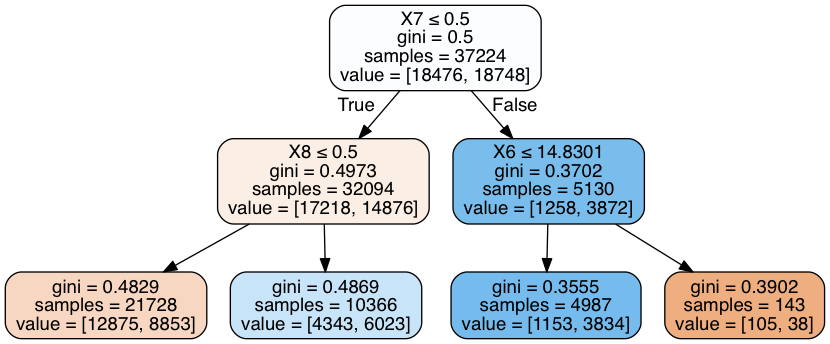

In [29]:
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [61]:
small_model.predict(sample_validation_data.drop('safe_loans',axis=1).as_matrix())

array([ 1, -1, -1,  1])

## Evaluating accuracy of the decision tree model

In [34]:
print('The training accuracy of small_model is:',small_model.score(X, y))
print('The training accuracy of decision_tree_model is:', decision_tree_model.score(X, y))

The accuracy of small_model is: 0.613502041694
The accuracy of decision_tree_model is: 0.640527616591


In [44]:
y_validation = validation_data['safe_loans'].as_matrix()
X_validation = validation_data.drop('safe_loans',axis=1).as_matrix()

In [37]:
print('The validation accuracy of the small_model is:', small_model.score(X_validation, y_validation))
print('The validation accuracy of the decision_tree_model is:', decision_tree_model.score(X_validation, y_validation))

The validation accuracy of the small_model is: 0.619345109866
The validation accuracy of the decision_tree_model is: 0.636148211978


## Evaluating accuracy of a complex decision tree model

In [39]:
clf_complex =DecisionTreeClassifier(max_depth=10)
big_model = clf_complex.fit(X, y)

In [40]:
print('The training accuracy of the big_model is:', big_model.score(X, y))
print('The validation accuracy of the big_model is:', big_model.score(X_validation, y_validation))

The training accuracy of the big_model is: 0.66379217709
The validation accuracy of the big_model is: 0.62623869022


## Quantifying the cost of mistakes

 - False negatives: Loans that were actually safe but were predicted to be risky. This results in an oppurtunity cost of loosing a loan that would have otherwise been accepted.
 - False positives: Loans that were actually risky but were predicted to be safe. These are much more expensive because it results in a risky loan being given.
 - Correct predictions: All correct predictions don't typically incur any cost.

In [ ]:
correct = sum([1 if pred==actual else 0 for pred,actual in zip(labels,sentiment)])
mistakes = sum([1 if pred!=actual else 0 for pred,actual in zip(labels,sentiment)])
total = len(sentiment)
print('num correct:',correct,';num mistakes:',mistakes,';total:',total)
print('Accuracy {0}%'.format((correct/total*100)))

In [47]:
predictions = decision_tree_model.predict(X_validation)

In [49]:
false_negatives = sum([1 if pred==-1 and val==1 else 0 for pred,val in zip(predictions,y_validation)])
print('Total number false negatives is:', false_negatives)

Total number false negatives is: 1717


In [50]:
false_positives = sum([1 if pred==1 and val==-1 else 0 for pred,val in zip(predictions, y_validation)])
print('Total number of false positives is:', false_positives)

Total number of false positives is: 1661


In [51]:
correct_predictions = sum([1 if pred==actual else 0 for pred,actual in zip(predictions,y_validation)])
print('Total number of correct predictions is:', correct_predictions)

Total number of correct predictions is: 5906


In [52]:
print('Total cost of mistakes is: ${}'.format(10000*false_negatives+20000*false_positives))

Total cost of mistakes is: $50390000
